In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
import numpy as np
import pandas as pd
import os
from skimage.transform import resize
from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
from skimage.io import imread, imshow #, concatenate_images
import PIL 
from PIL import Image
import re

['manualdraw', 'carvana-image-masking-challenge']


Using TensorFlow backend.


In [2]:
!mkdir images
#!ls -l '../input/train'

In [3]:
def files_names_in_path(path="",extension=".jpg"):
    files = []
    masks = []
    for f in os.listdir(path):
        filename, file_extension = os.path.splitext(f)
        if file_extension == '.gif':
            files.append(filename.replace('_mask','')+".jpg")
            masks.append(filename+"_mask.gif")
            
    return files, masks
car_path = '../input/carvana-image-masking-challenge/train/'
mask_path = '../input/carvana-image-masking-challenge/train_masks/'
input_files,input_masks = files_names_in_path(mask_path)

print(input_files[0:5])


['4b74275babf7_02.jpg', '3071362591f7_04.jpg', '0495dcf27283_10.jpg', 'd1a3af34e674_01.jpg', 'fc237174b128_09.jpg']


[[[0.95686275 0.95294118 0.97254902]
  [0.95686275 0.95294118 0.97254902]
  [0.95686275 0.95294118 0.97254902]
  ...
  [0.91764706 0.90196078 0.90588235]
  [0.91764706 0.90196078 0.90588235]
  [0.91764706 0.90196078 0.90588235]]

 [[0.95686275 0.95294118 0.97254902]
  [0.95686275 0.95294118 0.97254902]
  [0.95686275 0.95294118 0.97254902]
  ...
  [0.91764706 0.90196078 0.90588235]
  [0.91764706 0.90196078 0.90588235]
  [0.91764706 0.90196078 0.90588235]]

 [[0.95686275 0.95294118 0.97254902]
  [0.95686275 0.95294118 0.97254902]
  [0.95686275 0.95294118 0.97254902]
  ...
  [0.91764706 0.90196078 0.90588235]
  [0.91764706 0.90196078 0.90588235]
  [0.91764706 0.90196078 0.90588235]]

 ...

 [[0.83137255 0.83137255 0.82352941]
  [0.83137255 0.83137255 0.82352941]
  [0.83137255 0.83137255 0.82352941]
  ...
  [0.90588235 0.90588235 0.90588235]
  [0.90588235 0.90588235 0.90588235]
  [0.90588235 0.90588235 0.90588235]]

 [[0.83137255 0.83137255 0.82352941]
  [0.83137255 0.83137255 0.82352941]


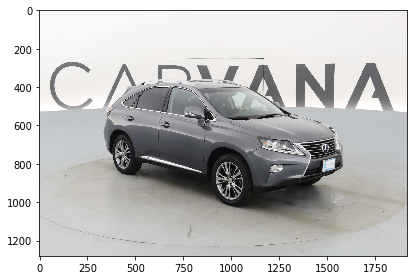

In [4]:
def load_image_and_normalize_and_resize(file_path="",normalize=True):
    if normalize:
        return (imread(file_path)/255)
    else:
        return (imread(file_path))
    

print(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]))
print(imshow(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,2)[0])))
print(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape)
HEIGH = load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape[0]
WIDTH = load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape[1]

In [5]:
# !ls '../input/train_masks'

In [6]:
mask = pd.read_csv('../input/carvana-image-masking-challenge/train_masks.csv')

In [7]:
len(mask)

5088

In [8]:
# ignore this function not needed finally... reference https://www.kaggle.com/robertkag/rle-to-mask-converter finally not used but i like this function i saved..

import numpy as np # linear algebra
#(1280, 1918, 3)

def rleToMask(rleString,height,width):
    rows, cols = height,width
    rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    img = np.zeros(rows*cols,dtype=np.uint8)
    for index,length in rlePairs:
        index -= 1
        img[index:index+length] = 255
    img = img.reshape(cols,rows)
    img = img.T
    return img

In [9]:
#index=3
#temp_mask = rleToMask(mask['rle_mask'][3],WIDTH,HEIGH)
#print(temp_mask.shape)
#rotated_mask = np.rot90(np.rot90(np.rot90(temp_mask)))
#imshow(rotated_mask)


In [10]:
len(input_files)

5088

In [11]:
# empezamos a trabajar para obtener la mascara del coche solo nos interesa el coche para mejorar el performanc
# ademas queremos simular los trazos humanos extrayendo los edges del coche (pero solo del coche, el fondo no nos interesa)
import cv2
indx=5000
carimage = car_path+input_files[indx]
maskimage = mask_path+input_files[indx].replace('.jpg','_mask.gif')

print(carimage)
print(maskimage)
img = cv2.imread(carimage)
#mask = cv2.imread(maskimage)
mask=imread(maskimage)
print(mask)

# get first masked value (foreground)
fg = cv2.bitwise_or(img, img, mask=mask)
# get second masked value (background) mask must be inverted
mask = cv2.bitwise_not(mask)
background = np.full(img.shape, 255, dtype=np.uint8)
bk = cv2.bitwise_or(background, background, mask=mask)

# combine foreground+background
final = cv2.bitwise_or(fg, bk)



../input/carvana-image-masking-challenge/train/fff9b3a5373f_12.jpg
../input/carvana-image-masking-challenge/train_masks/fff9b3a5373f_12_mask.gif
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


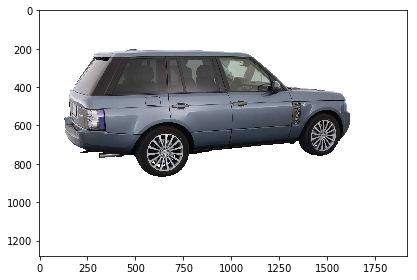

In [12]:
imshow(final)

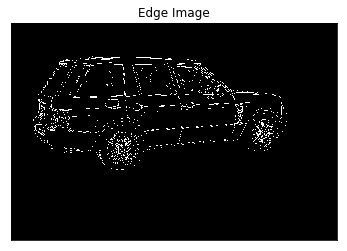

In [13]:
# example from opencv web page
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = final
edges = cv2.Canny(img,50,100)

#plt.subplot(121),
plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
#plt.subplot(122),
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


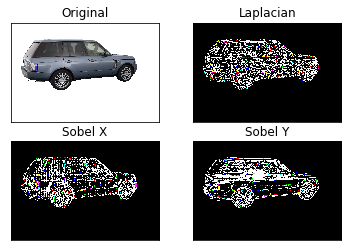

In [14]:
# example from opencv web page
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = final

laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

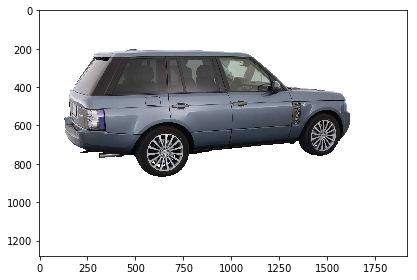

In [15]:
imshow(final)

(1280, 1918)


255

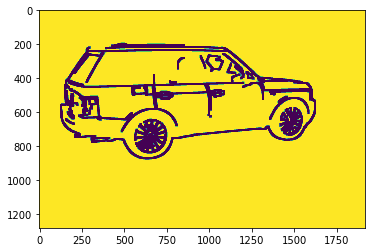

In [16]:
#reference https://www.kaggle.com/ayalamann/bounding-boxes-using-image-processing
img=final
def get_edge_v2_randoms(img):
    choise=[3,5,7]
    x = np.random.choice(choise,1)
    
    blurred = cv2.GaussianBlur(img, (x,x), 0) # Remove noise
    #close the small line gaps using errosion
    x = np.random.randint(2,5)
    kernel = np.ones((x,x), np.uint8)
    x = np.random.randint(2,5)
    erode = cv2.erode(blurred, kernel, iterations = x)
    # plt.imshow(erode)
    #cannyedge 
    def canny_edge_detector(input_img, threshold1, threshold2, draw=True, save=True):
        canny_img = cv2.cvtColor(np.copy(input_img), cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(canny_img, threshold1, threshold2)
        return edges
    #try adding Eroding before edge detection(increase black lines)
    x = np.random.randint(80,125)
    y = np.random.randint(135,180)
    canny_edges = canny_edge_detector(input_img=erode, threshold1=100, threshold2=150) 
    # plt.imshow(canny_edges)

    #close the small line gaps using dilation
    x = np.random.randint(2,5)
    kernel = np.ones((x,x), np.uint8)
    x = np.random.randint(2,5)
    dilation_canny = cv2.dilate(canny_edges, kernel, iterations = x)
    
    x = np.random.choice(choise,1)
    canny_blurred = cv2.GaussianBlur(dilation_canny, (x,x), 0) # Remove noise
    return np.invert(canny_blurred)

def get_edge_v2(img):
    blurred = cv2.GaussianBlur(img, (7,7), 0) # Remove noise
    #close the small line gaps using errosion
    kernel = np.ones((3,3), np.uint8)
    erode = cv2.erode(blurred, kernel, iterations = 3)
    plt.imshow(erode)
    #cannyedge 
    def canny_edge_detector(input_img, threshold1, threshold2, draw=True, save=True):
        canny_img = cv2.cvtColor(np.copy(input_img), cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(canny_img, threshold1, threshold2)
        return edges
    #try adding Eroding before edge detection(increase black lines)
    canny_edges = canny_edge_detector(input_img=erode, threshold1=100, threshold2=150) 
    plt.imshow(canny_edges)

    #close the small line gaps using dilation
    kernel = np.ones((5,5), np.uint8)
    dilation_canny = cv2.dilate(canny_edges, kernel, iterations = 3)
    canny_blurred = cv2.GaussianBlur(dilation_canny, (3,3), 0) # Remove noise
    return np.invert(canny_blurred)
ret =get_edge_v2(final)
plt.imshow(ret)
print(ret.shape)
np.max(ret)

In [17]:
#Fantastico! tenemos los trazos! y tenemos los estilos!


AxesImage(38.5601,27.8;382.64x245.485)


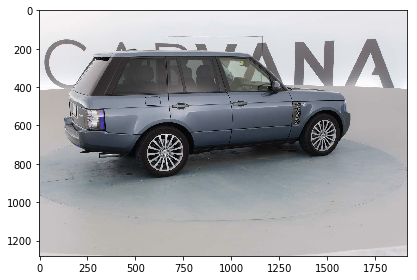

In [18]:
print(imshow(cv2.imread(carimage)))

AxesImage(10.8,27.8;410.4x245.825)


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


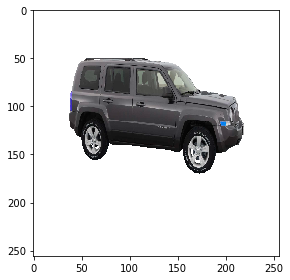

In [19]:
#try put in the box beauty with files generator
indx=4050
H=256
W=256
#(1280, 1918)

def downsample(img, h, w):
    return resize(img, (h, w), mode='constant', preserve_range=True)

def get_clean_image(path,path_mask,h, w):
    indx=5000
    
    img = cv2.imread(path)
    img = cv2.resize(img, (h, w))
    # print(imshow(img))
    #mask = cv2.imread(maskimage)
    mask=np.int8(downsample(imread(path_mask),h,w))
    # print(mask)
    #    print(mask)
    
    # get first masked value (foreground)
    fg = cv2.bitwise_or(img, img, mask=mask)
    # get second masked value (background) mask must be inverted
    mask = cv2.bitwise_not(mask)
    background = np.full(img.shape, 255, dtype=np.uint8)
    bk = cv2.bitwise_or(background, background, mask=mask)

    # combine foreground+background
    final = cv2.bitwise_or(fg, bk)
    #final=img
    return final
    #cannyedge 
def canny_edge_detector(input_img, threshold1, threshold2, draw=True, save=True):
    canny_img = cv2.cvtColor(np.copy(input_img), cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(canny_img, threshold1, threshold2)
    return edges
    
def get_edge_by_image(img):
    blurred = cv2.GaussianBlur(img, (7,7), 0) # Remove noise
    #close the small line gaps using errosion
    kernel = np.ones((3,3), np.uint8)
    erode = cv2.erode(blurred, kernel, iterations = 3)
    # plt.imshow(erode)

    #try adding Eroding before edge detection(increase black lines)
    canny_edges = canny_edge_detector(input_img=erode, threshold1=100, threshold2=150) 
    # plt.imshow(canny_edges)
    return np.invert(canny_edges).reshape((H,W,1))
    # refined remove noise
    #close the small line gaps using dilation
    kernel = np.ones((5,5), np.uint8)
    dilation_canny = cv2.dilate(canny_edges, kernel, iterations = 3)
    canny_blurred = cv2.GaussianBlur(dilation_canny, (3,3), 0) # Remove noise
    # plt.imshow(canny_blurred)
    # return np.invert(canny_edges).reshape((H,W,1))
carimage = car_path+input_files[indx]
maskimage = mask_path+input_files[indx].replace('.jpg','_mask.gif')
img = get_clean_image(carimage, maskimage,H,W)
print(imshow(img))


AxesImage(10.8,27.8;410.4x245.825)


(256, 256, 1)

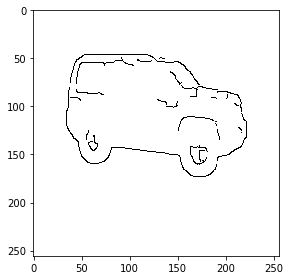

In [20]:
edge = get_edge_by_image(img)


print(imshow(edge.reshape(H,W)))
edge.shape

AxesImage(10.8,27.8;410.4x245.825)


(256, 256)

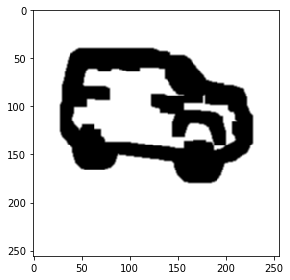

In [21]:
edgev2 = get_edge_v2(img)
print(imshow(edgev2.reshape(H,W)))
edgev2.shape

In [22]:
# prepare data generator! TODO in TFM add data augmentation

In [23]:
from imgaug import augmenters as iaa
import imgaug as ia
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)), # blur images with a sigma of 0 to 3.0
    sometimes(iaa.Affine(
            scale={"x": (1, 1.2), "y": (1, 1.2)}, # scale images to 80-120% of their size, individually per axis
            #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            #rotate=(-45, 45), # rotate by -45 to +45 degrees
            #shear=(-16, 16), # shear by -16 to +16 degrees
            #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            #cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ))
])


In [24]:
import skimage
BATCH_SIZE=32

def generator(path, batch_size=BATCH_SIZE, normalize=True):
    
    #retedge = np.zeros((batch_size,H,W,3),dtype=np.int16)
    #retimg = np.zeros((batch_size,H,W,3),dtype=np.int16)
    retedge = []
    retimg = []
    imgorig=[]
    for x in range(batch_size):
        car = np.random.choice(path,1)[0]
        carpath = car_path+car
        maskpath = mask_path+car.replace('.jpg','_mask.gif')
        #print(maskpath)
        img =  get_clean_image(carpath, maskpath, H, W)
    
        #print(np.max(img))
        #imshow(img)
        retimg.append(img)
 #       retimg[x] = img
        #imgorig = img
        # print(retimg[x].shape)
        #print(np.max(retimg[x]))
        mask = get_edge_v2(img)
        
        # mask = skimage.color.gray2rgb(mask.reshape(H,W,1))
        #print(mask.shape)
        #retedge[x] = mask
    #augmented images
    retimg = seq.augment_images(np.array(retimg))
    #for x in range(batch_size):
#        imgorig.append(retimg[x])
    
    for x in range(batch_size):
        #print(x)
        #mask = get_edge_by_image((retimg[x]/255).clip(0,1))
        #img = retimg[x]
        mask = get_edge_v2_randoms(retimg[x])
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        retedge.append(mask)

 #   if normalize:
#        retimg = retimg/255
       # retedge = retedge/255
    return np.array(retedge), retimg

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


AxesImage(10.8,27.8;410.4x245.825)


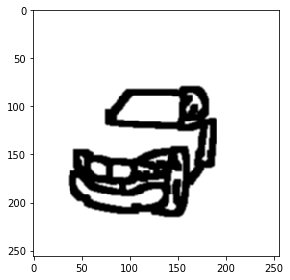

In [25]:
sampleEdge, sampleCar = generator(input_files,3,True)
print(imshow(sampleEdge[0]))

AxesImage(10.8,27.8;410.4x245.825)


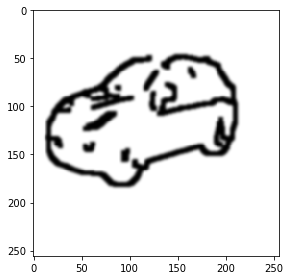

In [26]:
print(imshow(sampleEdge[1]))

AxesImage(10.8,27.8;410.4x245.825)


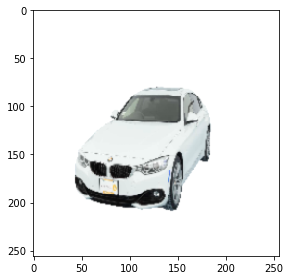

In [27]:
print(imshow(sampleCar[0]))


AxesImage(10.8,27.8;410.4x245.825)


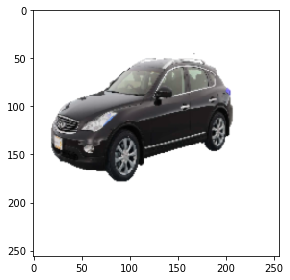

In [28]:
print(imshow(sampleCar[1]))

In [29]:
from sklearn.model_selection import train_test_split
train_input, test_input, _, _ = train_test_split(input_files, input_files, test_size=0.15, random_state=42)
print(len(train_input))
print(len(test_input))

4324
764


In [30]:
# ok we have all needed canyedge downsamples and generator let go with the model!
import scipy

from keras.datasets import mnist
#from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
#from data_loader import DataLoader
import numpy as np
import os

from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints
from keras import backend as K


class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
class DiscoGAN():
    def __init__(self):
        # Input shape

        self.img_rows = H
        self.img_cols = W
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'cartedge'
        #self.data_loader = DataLoader(dataset_name=self.dataset_name,
        #                              img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 16
        self.df = 16

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Objectives
        # + Adversarial: Fool domain discriminators
        # + Translation: Minimize MAE between e.g. fake B and true B
        # + Cycle-consistency: Minimize MAE between reconstructed images and original
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        fake_B, fake_A,
                                        reconstr_A, reconstr_B ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                              optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, normalize=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalize:
                d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, normalize=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1,
                            padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):

           # for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------
            #imgs_A,imgs_B = generator_cyclegan(target_files,input_files,batch_size,False)
            imgs_A,imgs_B = generator(train_input, batch_size, False)
            imgs_A = (imgs_A / 127.5) -1
            imgs_B = (imgs_B / 127.5) -1
                # Translate images to opposite domain
            fake_B = self.g_AB.predict(imgs_A)
            fake_A = self.g_BA.predict(imgs_B)

            # Train the discriminators (original images = real / translated = Fake)
            dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
            dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
            dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

            dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
            dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
            dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

            # Total disciminator loss
            d_loss = 0.5 * np.add(dA_loss, dB_loss)

            # ------------------
            #  Train Generators
            # ------------------

            # Train the generators
            g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, valid, \
                                                                     imgs_B, imgs_A, \
                                                                     imgs_A, imgs_B])

            elapsed_time = datetime.datetime.now() - start_time
            # Plot the progress
            print ("[%d] time: %s, [d_loss: %f, g_loss: %f]" % (epoch,
                                                                   # self.data_loader.n_batches,
                                                                    elapsed_time,
                                                                    d_loss[0], g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 3
        # imgs_A,imgs_B = generator_cyclegan(target_files,input_files,1,False)
        imgs_A,imgs_B = generator(test_input, 1, False)
        imgs_A = (imgs_A / 127.5) -1
        imgs_B = (imgs_B / 127.5) -1
        
#        imgs_A, imgs_B = self.data_loader.load_data(batch_size=1, is_testing=True)

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/disco_gan_%d.png" % ( epoch))
        plt.close()




In [31]:
#gan = DiscoGAN()
#gan.train(epochs=1000, batch_size=16, sample_interval=5)

In [32]:
!ls '../input/manualdraw/'

Lincoln Continental drawing.JPG  images.png	index.jpeg
images.jpeg			 images22.jpeg


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


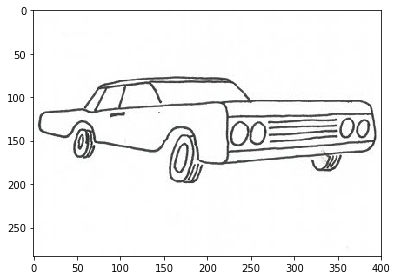

In [33]:
#LA PRUEBA DE FUEGO!! LO PROBAMOS CON UN DIBUJO 100% MANUAL!
imagemanual = load_image_and_normalize_and_resize('../input/manualdraw/Lincoln Continental drawing.JPG',False)
imshow(imagemanual)
imagemanual=(downsample(imagemanual,H,W)/127.5)-1

In [34]:

fakeB = gan.g_AB.predict(imagemanual.reshape(1,H,W,3))
fakeB = 0.5 * fakeB + 0.5
# fakeB = (fakeB)*127.5

# fakeA = gan.g_BA.predict(imgB)
#fakeA = 0.5 * fakeA + 0.5
#fakeA = (fakeA+1)*127.5

imshow(fakeB[0])

NameError: name 'gan' is not defined

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


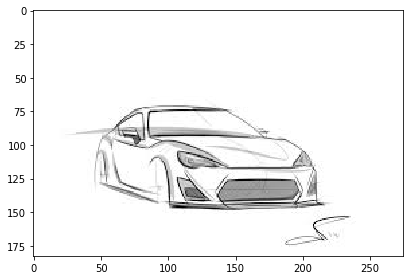

In [35]:
#LA PRUEBA DE FUEGO!! LO PROBAMOS CON UN DIBUJO 100% MANUAL!
imagemanual = load_image_and_normalize_and_resize('../input/manualdraw/index.jpeg',False)
imshow(imagemanual)
imagemanual=(downsample(imagemanual,H,W)/127.5)-1

In [36]:

fakeB = gan.g_AB.predict(imagemanual.reshape(1,H,W,3))
fakeB = 0.5 * fakeB + 0.5
# fakeB = (fakeB)*127.5

# fakeA = gan.g_BA.predict(imgB)
#fakeA = 0.5 * fakeA + 0.5
#fakeA = (fakeA+1)*127.5

imshow(fakeB[0])

NameError: name 'gan' is not defined

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


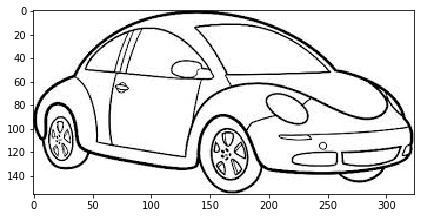

In [37]:

#LA PRUEBA DE FUEGO!! LO PROBAMOS CON UN DIBUJO 100% MANUAL!
imagemanual = load_image_and_normalize_and_resize('../input/manualdraw/images.jpeg',False)
imshow(imagemanual)
imagemanual=(downsample(imagemanual,H,W)/127.5)-1

In [38]:

fakeB = gan.g_AB.predict(imagemanual.reshape(1,H,W,3))
#fakeB = 0.5 * fakeB + 0.5
# fakeB = (fakeB)*127.5

# fakeA = gan.g_BA.predict(imgB)
#fakeA = 0.5 * fakeA + 0.5
#fakeA = (fakeA+1)*127.5

imshow(fakeB[0])

NameError: name 'gan' is not defined

In [39]:
!ls './images'
imshow('./images/disco_gan_255.png')

FileNotFoundError: [Errno 2] No such file or directory: './images/disco_gan_255.png'

(1, 256, 256, 3)


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


NameError: name 'gan' is not defined

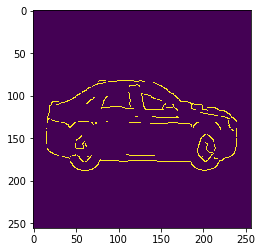

In [40]:
imgA,imgB = generator(test_input,1,False)
print(imgA.shape)
imgA = (imgA/127.5)-1
fakeB = gan.g_AB.predict(imgA)
fakeB = 0.5 * fakeB + 0.5
# fakeB = (fakeB)*127.5

fakeA = gan.g_BA.predict(imgB)
#fakeA = 0.5 * fakeA + 0.5
#fakeA = (fakeA+1)*127.5

imshow(imgA[0])


In [41]:
imshow(fakeB[0])

NameError: name 'fakeB' is not defined

(1, 256, 256, 3)


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


NameError: name 'gan' is not defined

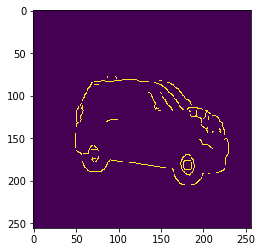

In [42]:
imgA,imgB = generator(train_input,1,False)
print(imgA.shape)
imgA = (imgA/127.5)-1
fakeB = gan.g_AB.predict(imgA)
fakeB = 0.5 * fakeB + 0.5

fakeA = gan.g_BA.predict(imgB)
fakeA = 0.5 * fakeA + 0.5

imshow(imgA[0])

In [43]:
imshow(fakeB[0])

NameError: name 'fakeB' is not defined

(1, 256, 256, 3)


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


NameError: name 'gan' is not defined

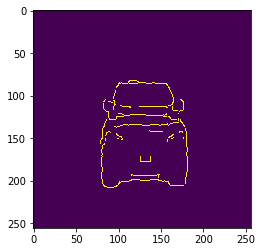

In [44]:
imgA,imgB = generator(train_input,1,False)
print(imgA.shape)
imgA = (imgA/127.5)-1
fakeB = gan.g_AB.predict(imgA)
fakeB = 0.5 * fakeB + 0.5

fakeA = gan.g_BA.predict(imgB)
fakeA = 0.5 * fakeA + 0.5

imshow(imgA[0])

In [45]:
imshow(fakeB[0])

NameError: name 'fakeB' is not defined

(1, 256, 256, 3)


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


NameError: name 'gan' is not defined

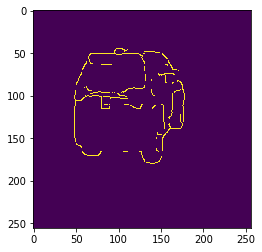

In [46]:
imgA,imgB = generator(test_input,1,False)
print(imgA.shape)
imgA = (imgA/127.5)-1
fakeB = gan.g_AB.predict(imgA)
fakeB = 0.5 * fakeB + 0.5

fakeA = gan.g_BA.predict(imgB)
fakeA = 0.5 * fakeA + 0.5

imshow(imgA[0])

In [47]:
imshow(fakeB[0])

NameError: name 'fakeB' is not defined

(1, 256, 256, 3)


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


NameError: name 'gan' is not defined

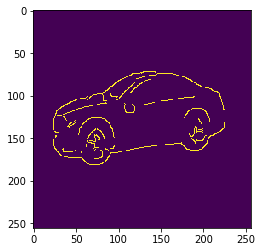

In [48]:
imgA,imgB = generator(test_input,1,False)
print(imgA.shape)
imgA = (imgA/127.5)-1
fakeB = gan.g_AB.predict(imgA)
fakeB = 0.5 * fakeB + 0.5

fakeA = gan.g_BA.predict(imgB)
fakeA = 0.5 * fakeA + 0.5

imshow(imgA[0])

In [49]:

imshow(fakeB[0])

NameError: name 'fakeB' is not defined

(1, 256, 256, 3)


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


NameError: name 'gan' is not defined

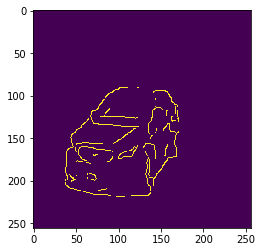

In [50]:
imgA,imgB = generator(test_input,1,False)
print(imgA.shape)
imgA = (imgA/127.5)-1
fakeB = gan.g_AB.predict(imgA)
fakeB = 0.5 * fakeB + 0.5

fakeA = gan.g_BA.predict(imgB)
fakeA = 0.5 * fakeA + 0.5

imshow(imgA[0])

In [51]:
imshow(fakeB[0])

NameError: name 'fakeB' is not defined

(1, 256, 256, 3)


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


NameError: name 'gan' is not defined

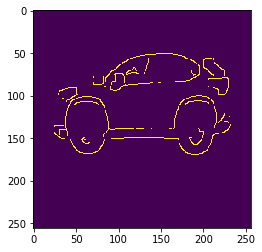

In [52]:
imgA,imgB = generator(train_input,1,False)
print(imgA.shape)
imgA = (imgA/127.5)-1
fakeB = gan.g_AB.predict(imgA)
fakeB = 0.5 * fakeB + 0.5

fakeA = gan.g_BA.predict(imgB)
fakeA = 0.5 * fakeA + 0.5

imshow(imgA[0])

In [53]:
imshow(fakeB[0])

NameError: name 'fakeB' is not defined

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/400]  [D loss: 2.095309, acc:  25%] [G loss: 94.297279] time: 0:00:12.664422
[Epoch 1/400]  [D loss: 6.159882, acc:  21%] [G loss: 73.874779] time: 0:00:16.430827
[Epoch 2/400]  [D loss: 3.930230, acc:  13%] [G loss: 63.216072] time: 0:00:19.717745
[Epoch 3/400]  [D loss: 1.718199, acc:  29%] [G loss: 55.510185] time: 0:00:22.937962
[Epoch 4/400]  [D loss: 1.092039, acc:  32%] [G loss: 49.489880] time: 0:00:25.823897
[Epoch 5/400]  [D loss: 0.883393, acc:  39%] [G loss: 48.844707] time: 0:00:28.755662
[Epoch 6/400]  [D loss: 0.762098, acc:  42%] [G loss: 45.595673] time: 0:00:32.101302
[Epoch 7/400]  [D loss: 0.733560, acc:  43%] [G loss: 43.476238] time: 0:00:35.041748
[Epoch 8/400]  [D loss: 0.615125, acc:  48%] [G loss: 38.765285] time: 0:00:37.959948
[Epoch 9/400]  [D loss: 0.593248, acc:  47%] [G loss: 35.733879] time: 0:00:40.795692
[Epoch 10/400]  [D loss: 0.549096, acc:  53%] [G loss: 35.351795] time: 0:00:43.628875
[Epoch 11/400]  [D loss: 0.534638, acc:  51%] [G loss

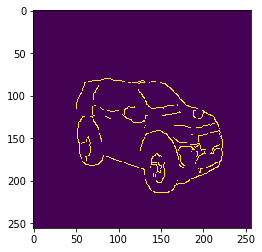

In [54]:
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
#from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
#from data_loader import DataLoader
import numpy as np
import os

class Pix2Pix():
    def __init__(self):
        # Input shape
        self.img_rows = H
        self.img_cols = W
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'facades'
        # self.data_loader = DataLoader(dataset_name=self.dataset_name,
        #                                        img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 32

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

        # Build the generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])

        self.combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
                imgs_B, imgs_A = generator(train_input, batch_size, False)
            #for batch_i in range(batch_size):
#            for batch_i, (imgs_A, imgs_B) in enumerate(allimgs_A,allimgs_B):
                imgs_A = (imgs_A/127.5)-1
                imgs_B = (imgs_B/127.5)-1
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Condition on B and generate a translated version
                
                fake_A = self.generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress [Batch %d/%d]
                print ("[Epoch %d/%d]  [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))

                # If at save interval => save generated image samples
                if epoch % sample_interval == 0:
                    self.sample_images(epoch)

    def sample_images(self, epoch):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 3, 3
        
        imgs_B, imgs_A = generator(test_input, 3, False)
        # imgs_A, imgs_B = self.data_loader.load_data(batch_size=3, is_testing=True)
        
        imgs_A = (imgs_A/127.5)-1
        imgs_B = (imgs_B/127.5)-1
        
        fake_A = self.generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d.png" % (self.dataset_name, epoch))
        plt.close()


gan = Pix2Pix()
gan.train(epochs=400, batch_size=32, sample_interval=5)

0.png	 135.png  175.png  215.png  255.png  30.png   340.png  380.png	60.png
10.png	 140.png  180.png  220.png  260.png  300.png  345.png  385.png	65.png
100.png  145.png  185.png  225.png  265.png  305.png  35.png   390.png	70.png
105.png  15.png   190.png  230.png  270.png  310.png  350.png  395.png	75.png
110.png  150.png  195.png  235.png  275.png  315.png  355.png  40.png	80.png
115.png  155.png  20.png   240.png  280.png  320.png  360.png  45.png	85.png
120.png  160.png  200.png  245.png  285.png  325.png  365.png  5.png	90.png
125.png  165.png  205.png  25.png   290.png  330.png  370.png  50.png	95.png
130.png  170.png  210.png  250.png  295.png  335.png  375.png  55.png


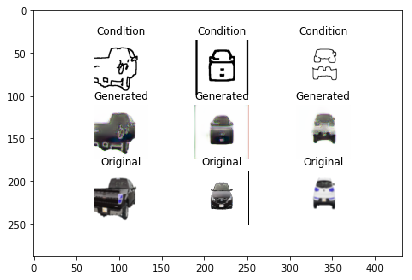

In [55]:
!ls './images/facades'
imshow('./images/facades/195.png')

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)


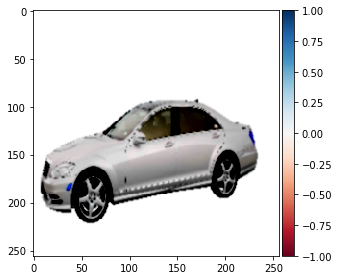

In [56]:
imgB,imgA = generator(train_input,1,False)
print(imgA.shape)
imgA = (imgA/127.5)-1
imgB = (imgB/127.5)-1
fakeB = gan.generator.predict(imgB)
fakeB = 0.5 * fakeB + 0.5
# fakeB = (fakeB)*127.5

# fakeA = gan.g_BA.predict(imgB)
#fakeA = 0.5 * fakeA + 0.5
#fakeA = (fakeA+1)*127.5

imshow(imgA[0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


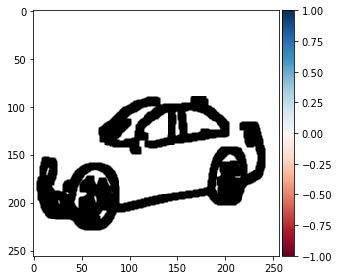

In [57]:
imshow(imgB[0])

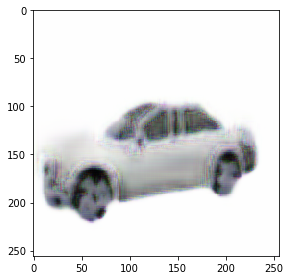

In [58]:
imshow(fakeB[0])

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)


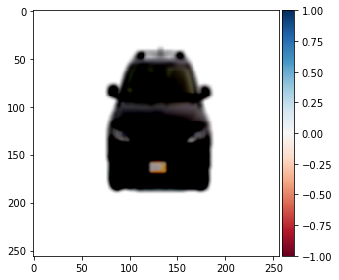

In [59]:
imgB,imgA = generator(test_input,1,False)
print(imgA.shape)
imgA = (imgA/127.5)-1
imgB = (imgB/127.5)-1
fakeB = gan.generator.predict(imgB)
fakeB = 0.5 * fakeB + 0.5
# fakeB = (fakeB)*127.5

# fakeA = gan.g_BA.predict(imgB)
#fakeA = 0.5 * fakeA + 0.5
#fakeA = (fakeA+1)*127.5

imshow(imgA[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


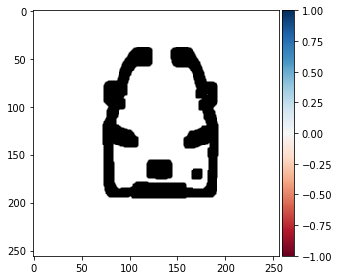

In [60]:
imshow(imgB[0])

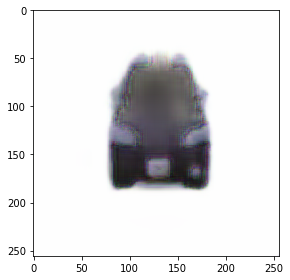

In [61]:
imshow(fakeB[0])

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)


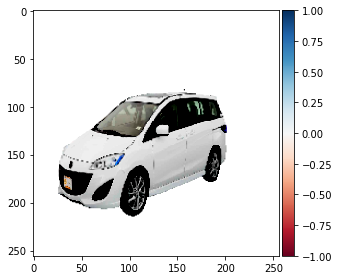

In [62]:
imgB,imgA = generator(test_input,1,False)
print(imgA.shape)
imgA = (imgA/127.5)-1
imgB = (imgB/127.5)-1
fakeB = gan.generator.predict(imgB)
fakeB = 0.5 * fakeB + 0.5
# fakeB = (fakeB)*127.5

# fakeA = gan.g_BA.predict(imgB)
#fakeA = 0.5 * fakeA + 0.5
#fakeA = (fakeA+1)*127.5

imshow(imgA[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


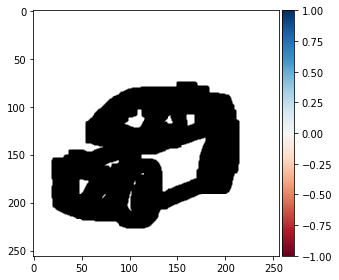

In [63]:
imshow(imgB[0])

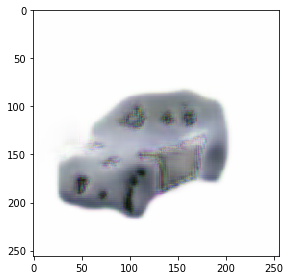

In [64]:
imshow(fakeB[0])

In [65]:
!ls "../input/manualdraw"

Lincoln Continental drawing.JPG  images.png	index.jpeg
images.jpeg			 images22.jpeg


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


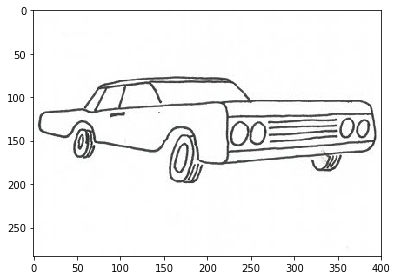

In [66]:
#LA PRUEBA DE FUEGO!! LO PROBAMOS CON UN DIBUJO 100% MANUAL!
imagemanual = load_image_and_normalize_and_resize('../input/manualdraw/Lincoln Continental drawing.JPG',False)
imshow(imagemanual)
imagemanual=downsample(imagemanual,H,W)/127.5-1


In [67]:
imagemanual.shape

(256, 256, 3)

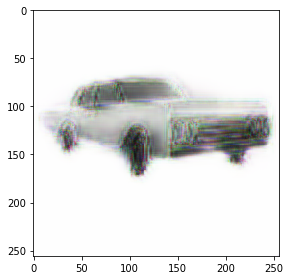

In [68]:

fakeB = gan.generator.predict(imagemanual.reshape(1,H,W,3))
fakeB = 0.5 * fakeB + 0.5
# fakeB = (fakeB)*127.5

# fakeA = gan.g_BA.predict(imgB)
#fakeA = 0.5 * fakeA + 0.5
#fakeA = (fakeA+1)*127.5

imshow(fakeB[0])

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


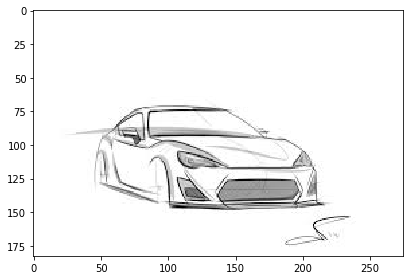

In [69]:
#LA PRUEBA DE FUEGO!! LO PROBAMOS CON UN DIBUJO 100% MANUAL!
imagemanual = load_image_and_normalize_and_resize('../input/manualdraw/index.jpeg',False)
imshow(imagemanual)
imagemanual=downsample(imagemanual,H,W)/127.5-1

In [70]:
imagemanual.shape

(256, 256, 3)

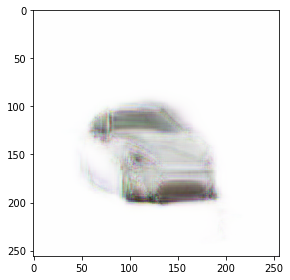

In [71]:

fakeB = gan.generator.predict(imagemanual.reshape(1,H,W,3))
fakeB = 0.5 * fakeB + 0.5
# fakeB = (fakeB)*127.5

# fakeA = gan.g_BA.predict(imgB)
#fakeA = 0.5 * fakeA + 0.5
#fakeA = (fakeA+1)*127.5

imshow(fakeB[0])

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


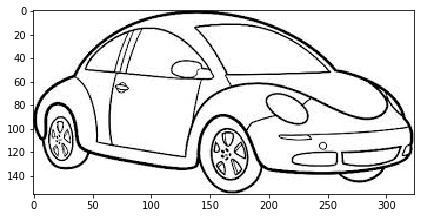

In [72]:
#LA PRUEBA DE FUEGO!! LO PROBAMOS CON UN DIBUJO 100% MANUAL!
imagemanual = load_image_and_normalize_and_resize('../input/manualdraw/images.jpeg',False)
imshow(imagemanual)
imagemanual=downsample(imagemanual,H,W)/127.5-1

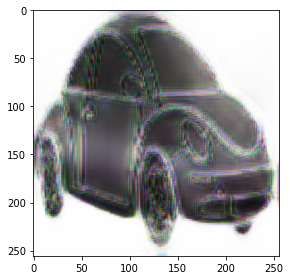

In [73]:

fakeB = gan.generator.predict(imagemanual.reshape(1,H,W,3))
fakeB = 0.5 * fakeB + 0.5
# fakeB = (fakeB)*127.5

# fakeA = gan.g_BA.predict(imgB)
#fakeA = 0.5 * fakeA + 0.5
#fakeA = (fakeA+1)*127.5

imshow(fakeB[0])